In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [56]:
covid_cases_data=pd.read_csv("covid_confirmed_usafacts.csv")
covid_cases_df=pd.DataFrame(covid_cases_data)
covid_cases_df.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2023-07-14,2023-07-15,2023-07-16,2023-07-17,2023-07-18,2023-07-19,2023-07-20,2023-07-21,2023-07-22,2023-07-23
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,19913,19913,19913,19913,19913,19913,19913,19913,19913,19913
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,70521,70521,70521,70521,70521,70521,70521,70521,70521,70521
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,8149,8149,8149,8149,8149,8149,8149,8149,8149,8149


In [57]:
covid_deaths_data=pd.read_csv("covid_deaths_usafacts.csv")
covid_deaths_df=pd.DataFrame(covid_deaths_data)
covid_deaths_df.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2023-07-14,2023-07-15,2023-07-16,2023-07-17,2023-07-18,2023-07-19,2023-07-20,2023-07-21,2023-07-22,2023-07-23
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,235,235,235,235,235,235,235,235,235,235
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,731,731,731,731,731,731,731,731,731,731
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,104,104,104,104,104,104,104,104,104,104
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,111,111,111,111,111,111,111,111,111,111


Linear Regression RMSE for NJ: 1596074.3607497062
Polynomial Regression RMSE for NJ (degree=3): 305498.3222371379


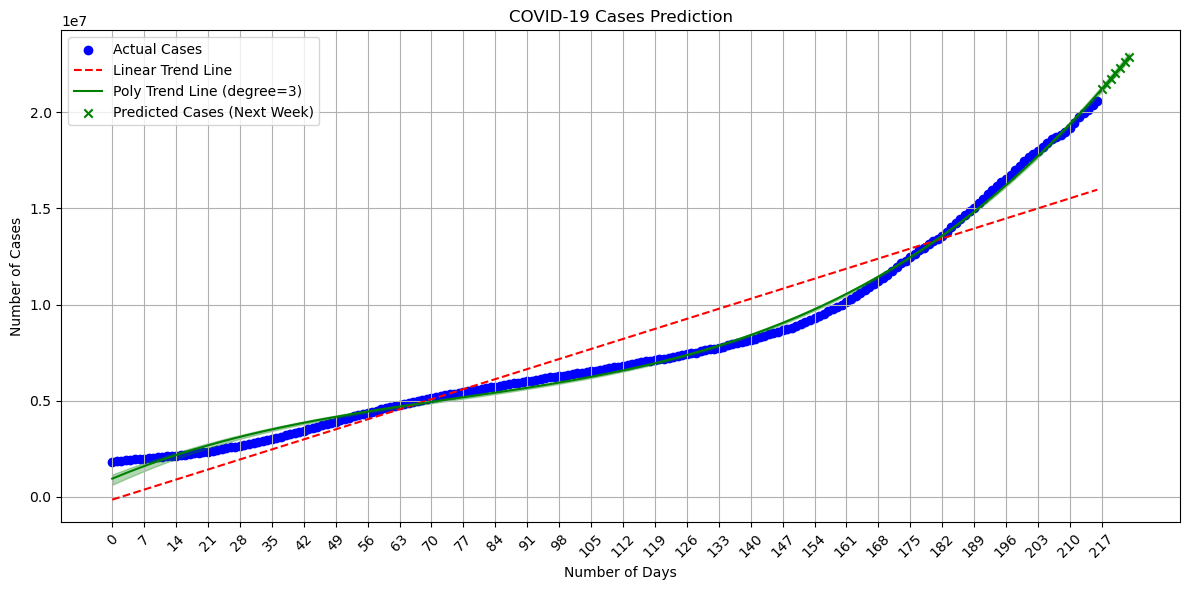

In [58]:
# Filter data for the specified date range
start_date="2020-06-01"
end_date="2021-01-03"
date_range=pd.date_range(start_date, end_date).strftime('%Y-%m-%d').tolist()
covid_cases_data=covid_cases_data[['countyFIPS', 'County Name', 'State']+date_range]
# Prepare data for analysis
cases_data=covid_cases_data[date_range].sum(axis=0).values
days_since_start=np.arange(len(date_range)).reshape(-1, 1)
# Fit linear regression model
reg_linear=LinearRegression().fit(days_since_start, cases_data.reshape(-1, 1))
# Calculate RMSE for linear regression
linear_predictions=reg_linear.predict(days_since_start)
linear_rmse=np.sqrt(mean_squared_error(cases_data, linear_predictions))
# Fit polynomial regression model
degree=3  # Change this if you want
poly_features=PolynomialFeatures(degree=degree)
X_poly=poly_features.fit_transform(days_since_start)
reg_poly=LinearRegression().fit(X_poly, cases_data.reshape(-1, 1))
# Calculate RMSE for polynomial regression
poly_predictions=reg_poly.predict(X_poly)
poly_rmse=np.sqrt(mean_squared_error(cases_data, poly_predictions))
# Print RMSE values
print(f"Linear Regression RMSE for NJ: {linear_rmse}")
print(f"Polynomial Regression RMSE for NJ (degree={degree}): {poly_rmse}")
# Bootstrap to calculate confidence interval
n_bootstraps=1000
bootstrap_predictions=[]
for _ in range(n_bootstraps):
    indices=np.random.choice(len(cases_data), size=len(cases_data), replace=True)
    X_boot=X_poly[indices]
    y_boot=cases_data[indices]
    reg_boot=LinearRegression().fit(X_boot, y_boot.reshape(-1, 1))
    X_plot_poly=poly_features.transform(np.arange(len(date_range)+7).reshape(-1, 1))
    bootstrap_predictions.append(reg_boot.predict(X_plot_poly))
# Calculate confidence interval
confidence_interval=np.percentile(bootstrap_predictions, [2.5, 97.5], axis=0)
# Flatten confidence interval arrays
confidence_interval_lower=confidence_interval[0].flatten()
confidence_interval_upper=confidence_interval[1].flatten()
# Plotting
plt.figure(figsize=(12, 6))
# Plot actual data
plt.scatter(days_since_start, cases_data, color='blue', label='Actual Cases')
# Plot linear regression trend line
plt.plot(days_since_start, reg_linear.predict(days_since_start), color='red', linestyle='--', label='Linear Trend Line')
# Plot polynomial regression trend line and confidence interval
X_plot_poly=poly_features.transform(np.arange(len(date_range)+7).reshape(-1, 1))
plt.plot(np.arange(len(date_range)+7), reg_poly.predict(X_plot_poly), color='green', label=f'Poly Trend Line (degree={degree})')
plt.fill_between(np.arange(len(date_range)+7), confidence_interval_lower, confidence_interval_upper, color='green', alpha=0.3)
# Predictions for the next week
days_future=np.arange(len(date_range), len(date_range)+7).reshape(-1, 1)
X_future_poly=poly_features.transform(days_future)
cases_pred=reg_poly.predict(X_future_poly)
# Plotting predictions
plt.scatter(days_future, cases_pred, color='green', marker='x', label='Predicted Cases (Next Week)')
plt.xlabel('Number of Days')
plt.ylabel('Number of Cases')
plt.title('COVID-19 Cases Prediction')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, len(date_range) + 7, 7), rotation=45)
plt.tight_layout()
plt.show()

Linear Regression RMSE for NJ: 13545.924691430659
Polynomial Regression RMSE for NJ (degree=3): 4762.935748761431


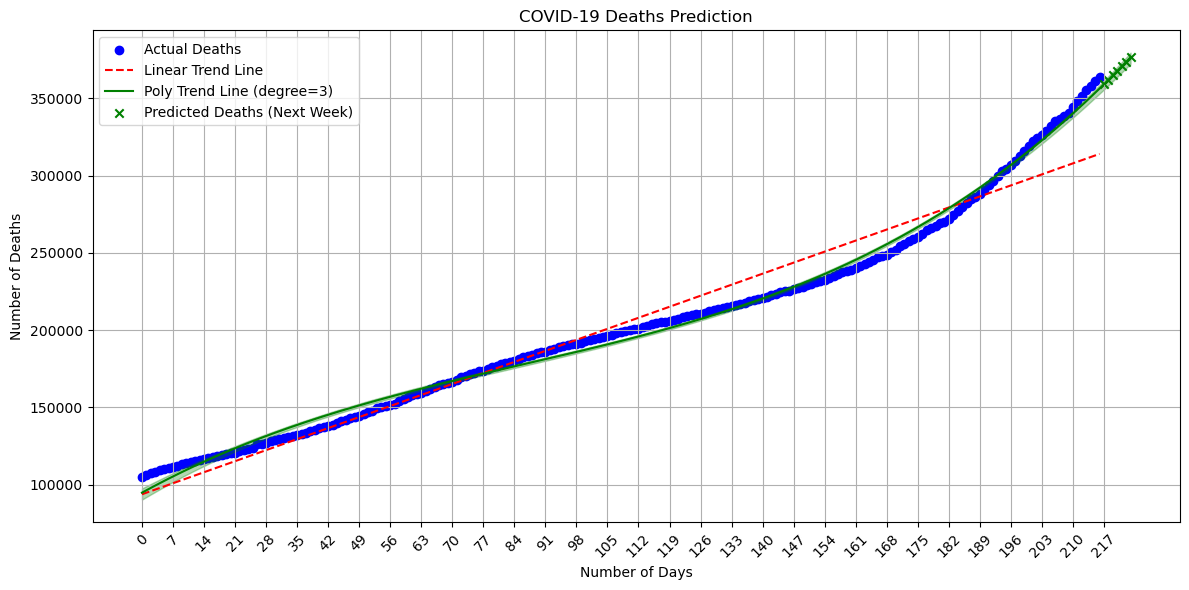

In [59]:
# Filter data for the specified date range
start_date="2020-06-01"
end_date="2021-01-03"
date_range=pd.date_range(start_date, end_date).strftime('%Y-%m-%d').tolist()
covid_deaths_data=covid_deaths_data[['countyFIPS', 'County Name', 'State']+date_range]
# Prepare data for analysis
deaths_data=covid_deaths_data[date_range].sum(axis=0).values
days_since_start=np.arange(len(date_range)).reshape(-1, 1)
# Fit linear regression model
reg_linear=LinearRegression().fit(days_since_start, deaths_data.reshape(-1, 1))
# Calculate RMSE for linear regression
linear_predictions=reg_linear.predict(days_since_start)
linear_rmse=np.sqrt(mean_squared_error(deaths_data, linear_predictions))
# Fit polynomial regression model
degree=3  # Change this if you want
poly_features=PolynomialFeatures(degree=degree)
X_poly=poly_features.fit_transform(days_since_start)
reg_poly=LinearRegression().fit(X_poly, deaths_data.reshape(-1, 1))
# Calculate RMSE for polynomial regression
poly_predictions=reg_poly.predict(X_poly)
poly_rmse=np.sqrt(mean_squared_error(deaths_data, poly_predictions))
# Print RMSE values
print(f"Linear Regression RMSE for NJ: {linear_rmse}")
print(f"Polynomial Regression RMSE for NJ (degree={degree}): {poly_rmse}")
# Bootstrap to calculate confidence interval
n_bootstraps=1000
bootstrap_predictions=[]
for _ in range(n_bootstraps):
    indices=np.random.choice(len(deaths_data), size=len(deaths_data), replace=True)
    X_boot=X_poly[indices]
    y_boot=deaths_data[indices]
    reg_boot=LinearRegression().fit(X_boot, y_boot.reshape(-1, 1))
    X_plot_poly=poly_features.transform(np.arange(len(date_range)+7).reshape(-1, 1))
    bootstrap_predictions.append(reg_boot.predict(X_plot_poly))
# Calculate confidence interval
confidence_interval=np.percentile(bootstrap_predictions, [2.5, 97.5], axis=0)
# Flatten confidence interval arrays
confidence_interval_lower=confidence_interval[0].flatten()
confidence_interval_upper=confidence_interval[1].flatten()
# Plotting
plt.figure(figsize=(12, 6))
# Plot actual data
plt.scatter(days_since_start, deaths_data, color='blue', label='Actual Deaths')
# Plot linear regression trend line
plt.plot(days_since_start, reg_linear.predict(days_since_start), color='red', linestyle='--', label='Linear Trend Line')
# Plot polynomial regression trend line and confidence interval
X_plot_poly=poly_features.transform(np.arange(len(date_range)+7).reshape(-1, 1))
plt.plot(np.arange(len(date_range)+7), reg_poly.predict(X_plot_poly), color='green', label=f'Poly Trend Line (degree={degree})')
plt.fill_between(np.arange(len(date_range)+7), confidence_interval_lower, confidence_interval_upper, color='green', alpha=0.3)
# Predictions for the next week
days_future=np.arange(len(date_range), len(date_range)+7).reshape(-1, 1)
X_future_poly=poly_features.transform(days_future)
deaths_pred=reg_poly.predict(X_future_poly)
# Plotting predictions
plt.scatter(days_future, deaths_pred, color='green', marker='x', label='Predicted Deaths (Next Week)')
plt.xlabel('Number of Days')
plt.ylabel('Number of Deaths')
plt.title('COVID-19 Deaths Prediction')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, len(date_range)+7, 7), rotation=45)
plt.tight_layout()
plt.show()

## Bias vs Variance Trade-Off

When creating machine learning models, it is important to understand how a high amount of bias and/or a high amount of variance can affect statistical models. A high bias model usually leads to the model being underfitted and does not perform well in tests.

On the other hand, a high variance model will usually overfit the data and lead to a complex model. This means that it could capture noise and then leads to poor performance when it comes to new or unseen data. There is a tradeoff becuase decreasing variance leads to increasing bias and the other way around.

In our example, above for Covid Deaths, we can see that the polynomial model seems to be following the actual values very closely. This could lead to overfitting if we were to increase the polynomial degree. This overfitting would be due to high variance. 

It is important to balance bias and variance in order to ensure that a model can perform well beyond the known values.

In [60]:
other_cases_data = pd.read_csv('total_cases.csv')
other_deaths_data = pd.read_csv('total_deaths.csv')

In [61]:
other_cases_data.head()

,date,World,Afghanistan,Africa,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,...,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Yemen,Zambia,Zimbabwe
0,2020-01-05,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-06,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-07,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-08,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Assuming 'UK' is the column name for the United Kingdom's data
uk_cases_data = other_cases_data['United Kingdom']
uk_deaths_data = other_deaths_data['United Kingdom']

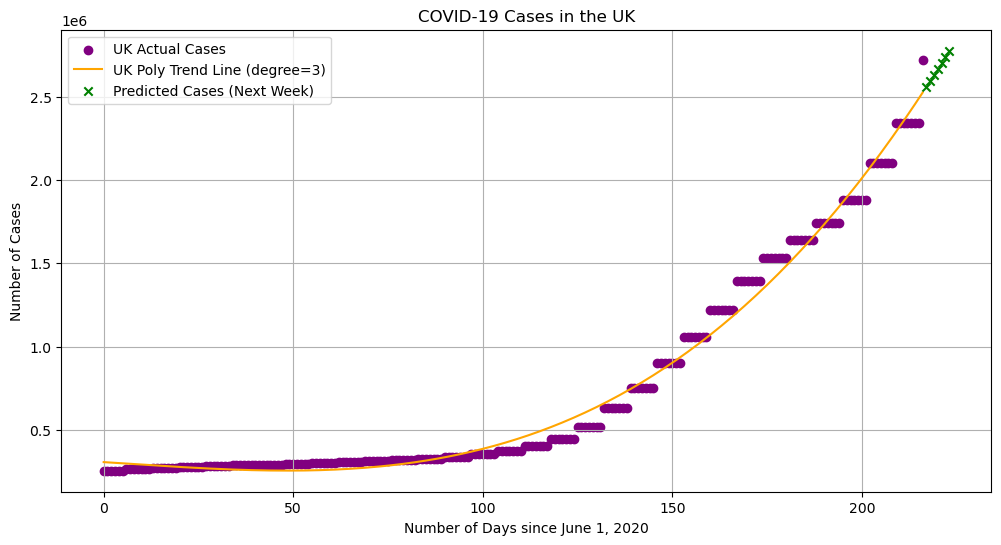

In [63]:
# Filter the UK data for the specified date range
uk_cases_data = other_cases_data['United Kingdom']
uk_deaths_data = other_deaths_data['United Kingdom']

# Convert index to datetime if necessary and filter by date range
other_cases_data['Date'] = pd.to_datetime(other_cases_data['date'])
uk_cases_data = uk_cases_data[(other_cases_data['Date'] >= '2020-06-01') & (other_cases_data['Date'] <= '2021-01-03')]
uk_deaths_data = uk_deaths_data[(other_cases_data['Date'] >= '2020-06-01') & (other_cases_data['Date'] <= '2021-01-03')]

# Assuming days_since_start is the array of days since 2020-06-01
days_since_start = np.arange(len(uk_cases_data))

# Fit the regression models (linear or polynomial as needed)
# Example with polynomial regression for cases
degree = 3
poly_features_uk = PolynomialFeatures(degree=degree)
X_poly_uk = poly_features_uk.fit_transform(days_since_start.reshape(-1, 1))
reg_poly_uk = LinearRegression().fit(X_poly_uk, uk_cases_data.values.reshape(-1, 1))

# Predictions for the next week
days_future=np.arange(len(date_range), len(date_range)+7).reshape(-1, 1)
X_future_poly=poly_features.transform(days_future)
cases_pred=reg_poly_uk.predict(X_future_poly)

# Plotting the data for visual comparison
plt.figure(figsize=(12, 6))
plt.scatter(days_since_start, uk_cases_data, color='purple', label='UK Actual Cases')
X_plot_poly_uk = poly_features_uk.transform(np.arange(len(uk_cases_data)).reshape(-1, 1))
plt.plot(np.arange(len(uk_cases_data)), reg_poly_uk.predict(X_plot_poly_uk), color='orange', label=f'UK Poly Trend Line (degree={degree})')
plt.scatter(days_future, cases_pred, color='green', marker='x', label='Predicted Cases (Next Week)')
plt.xlabel('Number of Days since June 1, 2020')
plt.ylabel('Number of Cases')
plt.title('COVID-19 Cases in the UK')
plt.legend()
plt.grid(True)
plt.show()

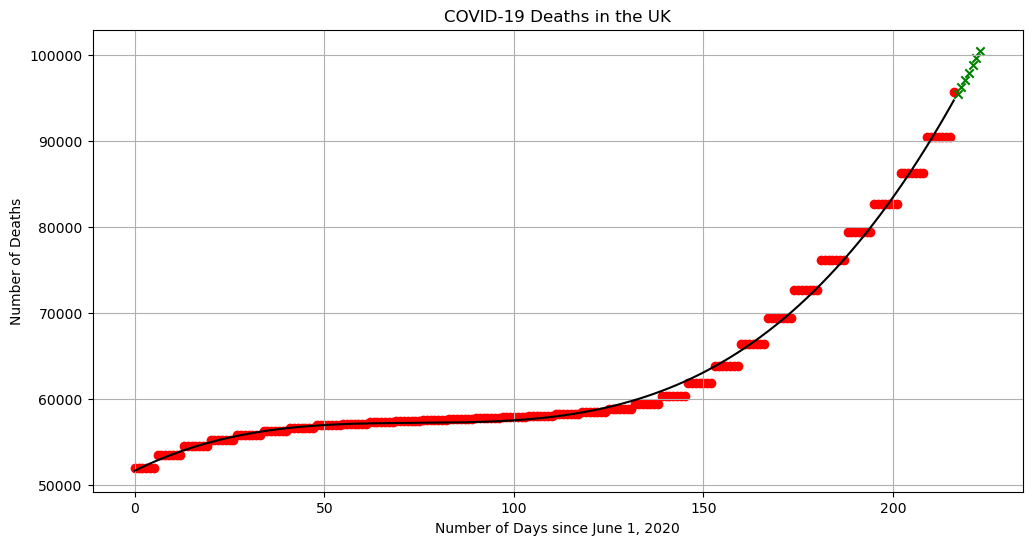

In [64]:
# Convert index to datetime if necessary and filter by date range
other_deaths_data['Date'] = pd.to_datetime(other_deaths_data['date'])  # Ensure the 'date' column is correct
uk_deaths_data = uk_deaths_data[(other_deaths_data['Date'] >= '2020-06-01') & (other_deaths_data['Date'] <= '2021-01-03')]

# Prepare the days_since_start based on the filtered data
days_since_start_deaths = np.arange(len(uk_deaths_data))

# Fit the regression models (linear or polynomial as needed)
# Using polynomial regression for deaths as an example
degree_deaths = 3
poly_features_uk_deaths = PolynomialFeatures(degree=degree_deaths)
X_poly_uk_deaths = poly_features_uk_deaths.fit_transform(days_since_start_deaths.reshape(-1, 1))
reg_poly_uk_deaths = LinearRegression().fit(X_poly_uk_deaths, uk_deaths_data.values.reshape(-1, 1))

# Predictions for the next week
days_future=np.arange(len(date_range), len(date_range)+7).reshape(-1, 1)
X_future_poly=poly_features.transform(days_future)
deaths_pred=reg_poly_uk_deaths.predict(X_future_poly)

# Plotting the deaths data for visual comparison
plt.figure(figsize=(12, 6))
plt.scatter(days_since_start_deaths, uk_deaths_data, color='red', label='UK Actual Deaths')
X_plot_poly_uk_deaths = poly_features_uk_deaths.transform(np.arange(len(uk_deaths_data)).reshape(-1, 1))
plt.plot(np.arange(len(uk_deaths_data)), reg_poly_uk_deaths.predict(X_plot_poly_uk_deaths), color='black', label=f'UK Poly Trend Line (degree={degree_deaths})')
plt.scatter(days_future, deaths_pred, color='green', marker='x', label='Predicted Deaths (Next Week)')
plt.xlabel('Number of Days since June 1, 2020')
plt.ylabel('Number of Deaths')
plt.title('COVID-19 Deaths in the UK')
plt.grid(True)
plt.show()

### Comparing Trends between US and UK

In [66]:
import plotly.graph_objects as go

us_trace = go.Scatter(x=days_since_start, y=cases_data, mode='lines', name='US')
uk_trace = go.Scatter(x=days_since_start, y=uk_cases_data, mode='lines', name='UK')

# Define layout
layout = go.Layout(
    title='COVID Cases Comparison: US vs UK',
    xaxis=dict(title='Date'),
    yaxis=dict(title='COVID Cases')
)

# Create figure and plot
fig = go.Figure(data=[us_trace, uk_trace], layout=layout)
fig.show()

In the above figure, we can see that the US has faced increased COVID cases compared to the UK. Not only have they faced more cases, but the rate at which cases increase in the US is far greater than that of the UK.

The data above starts at relatively similar locations, but we can see the US COVID cases skyrocket towards the 150-day mark. 

By the end of this time period, the UK has 2.7 million COVID cases, while the US has over 20 million cases.

From the previous graphs, we can also see that both countries trend upwards in an exponential way for cases and deaths. The US cases count starts linearly and then begins to increase exponentially around the 150-day mark. The UK on the other hand starts very slowly relative to the US and increases quickly at around 125 days.